In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/DATASET-balanced.csv
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-Obama.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/margot-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/linus-to-obama.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-biden.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/ryan-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/obama-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/musk-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/ryan-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-musk.wav
/kaggle/input/deep-voice-deepfake-

In [3]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load dataset

In [4]:
DATASET_PATH = "/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO"
df = pd.read_csv("/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/DATASET-balanced.csv",encoding='utf-8')
# df = pd.read_csv("../input/deep-voice-deepfake-voice-recognition/DATASET-balanced.csv", encoding='utf-8')
print(df.head())


   chroma_stft       rms  spectral_centroid  spectral_bandwidth      rolloff  \
0     0.338055  0.027948        2842.948867         4322.916759  6570.586186   
1     0.443766  0.037838        2336.129597         3445.777044  3764.949874   
2     0.302528  0.056578        2692.988386         2861.133180  4716.610271   
3     0.319933  0.031504        2241.665382         3503.766175  3798.641521   
4     0.420055  0.016158        2526.069123         3102.659519  5025.077899   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  ...  \
0            0.041050 -462.169586   90.311272  19.073769  24.046888  ...   
1            0.047730 -409.413422  120.348808  -7.161531   5.114784  ...   
2            0.080342 -318.996033  120.490273 -24.625771  23.891073  ...   
3            0.047180 -404.636749  136.320908   2.308172  -3.907071  ...   
4            0.051905 -410.497925  152.731400 -18.266771  51.993462  ...   

     mfcc12    mfcc13    mfcc14    mfcc15    mfcc16    mfcc17 

# Extract features from audio

In [5]:
# Check and clean column names
df.columns = df.columns.str.strip().str.lower()  # Convert to lowercase for consistency
print("Dataset Columns:", df.columns)

# Ensure the correct label column exists
if 'label' not in df.columns:
    raise KeyError("Expected column 'label' not found in dataset.")

# Prepare dataset (Drop label column to get feature matrix)
X = df.drop(columns=['label']).values  # Feature matrix
Y = df['label'].values  # Labels

# Encode labels
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
Y = to_categorical(Y)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Reshape X to match CNN input requirements (assuming it's not already in shape)
X_train = X_train[..., np.newaxis]  # Add channel dimension
X_test = X_test[..., np.newaxis]


Dataset Columns: Index(['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth',
       'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18',
       'mfcc19', 'mfcc20', 'label'],
      dtype='object')


# Prepare dataset

In [6]:
X = df.drop(columns=['label']).values  # Use existing features
Y = df['label'].values

# Encode labels
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
Y = to_categorical(Y)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Reshape X to match CNN input requirements
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# CNN Model with Regularization and Batch Normalization

In [7]:
model = Sequential([
    Conv1D(32, 3, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.2),
    
    Conv1D(64, 3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),
    
    Conv1D(128, 3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.4),
    
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compile model

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model with early stopping

In [9]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode labels
encoder = LabelEncoder()
Y = encoder.fit_transform(df['label'].values)  # Convert 'Real'/'Fake' to 0/1
Y = to_categorical(Y)  # Convert to one-hot encoding

# Extract features
X = df.drop(columns=['label']).values  # Use existing features

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Reshape X to match CNN input requirements
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Convert one-hot encoded labels back to single-label format for class weight calculation
y_train_labels = np.argmax(Y_train, axis=1)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weight_dict)

# Define CNN model with increased dropout
model = Sequential([
    Conv1D(32, 3, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),  # Increased dropout
    
    Conv1D(64, 3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.4),  # Increased dropout
    
    Conv1D(128, 3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.5),  # Increased dropout
    
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.6),  # Increased final dropout
    Dense(2, activation='softmax')
])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model before training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
epochs = 20
history = model.fit(
    X_train, Y_train,
    epochs=epochs,
    validation_data=(X_test, Y_test),
    batch_size=16,
    class_weight={0: class_weights[0], 1: class_weights[1]},
    callbacks=[early_stopping]
)


Class Weights: {0: 1.0, 1: 1.0}
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5457 - loss: 1.3512 - val_accuracy: 0.6549 - val_loss: 0.8463
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6091 - loss: 0.8651 - val_accuracy: 0.6740 - val_loss: 0.7593
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6842 - loss: 0.7891 - val_accuracy: 0.7776 - val_loss: 0.6696
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7333 - loss: 0.7054 - val_accuracy: 0.8171 - val_loss: 0.5657
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7642 - loss: 0.6496 - val_accuracy: 0.8281 - val_loss: 0.5240
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7768 - loss: 0.5984 - val_accuracy: 0.8408 - val_loss: 0.4733
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7935 - loss: 0.5713 - val_accuracy: 0.8786 - val_loss: 0.4172
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8031 - loss: 0.5349 - val_accuracy: 0.8896 - va

# Evaluate model

In [10]:
loss, acc = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {acc:.2f}")

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9429 - loss: 0.2697
Test Accuracy: 0.94


In [11]:
import sklearn.metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

accuracy = accuracy_score(Y_true, Y_pred_classes)
precision = sklearn.metrics.precision_score(Y_true, Y_pred_classes, average='weighted')
recall = recall_score(Y_true, Y_pred_classes, average='weighted')
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1 Score: 0.94


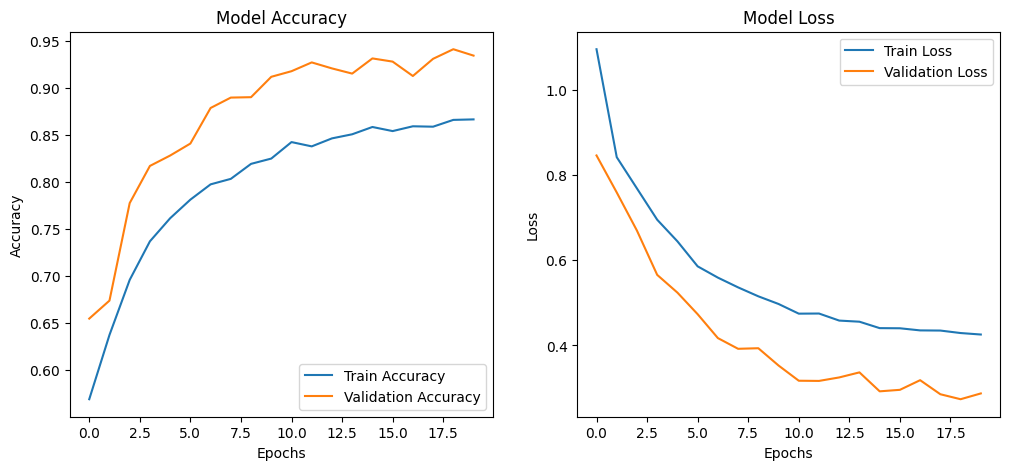

In [12]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

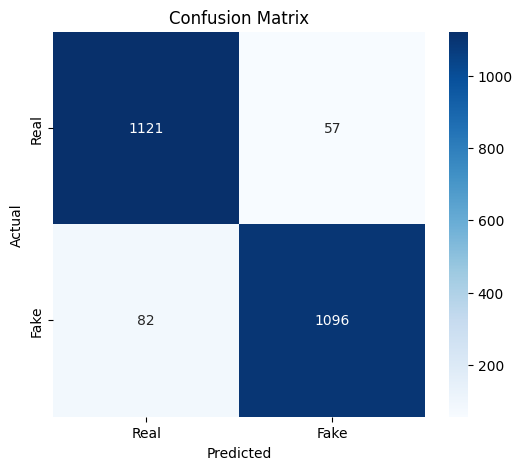

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [14]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train_labels = np.argmax(Y_train, axis=1)  # Convert one-hot to labels
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)


Class Weights: {0: 1.0, 1: 1.0}


 # Save model and label encoder

In [15]:
   
model.save("/kaggle/working/deepfake_audio_model.h5")
import pickle
with open("/kaggle/working/label_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)


# Function to extract features from a new audio file

In [97]:
import os
from tensorflow.keras.models import Sequential, load_model

print(os.path.exists("/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"))


True


In [99]:
def extract_features(file_path, max_pad_len=128):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        if mel_spec_db.shape[1] < max_pad_len:
            pad_width = max_pad_len - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :max_pad_len]
        
        print("Feature shape:", mel_spec_db.shape)  # Debugging line
        return mel_spec_db
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


In [20]:
!pip install resampy
!pip install --upgrade librosa resampy



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.0 MB/s eta 0:00:0000:0100:01


In [21]:
import resampy
import librosa
print(librosa.__version__)
import resampy
print(resampy.__version__)


0.10.2.post1
0.4.3


In [100]:
import librosa
import numpy as np

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)  # Load audio file
    feature = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=26)  # Extract 26 MFCCs
    feature = np.mean(feature, axis=1)  # Convert to 1D vector of size (26,)
    return feature


In [101]:
from tensorflow.keras.models import load_model
import numpy as np

def predict_audio(file_path):
    model = load_model("/kaggle/working/deepfake_audio_model.h5")
    
    # Extract features
    feature = extract_features(file_path)  

    if feature is not None:
        feature = np.expand_dims(feature, axis=0)  # Add batch dimension (1, 26)
        feature = np.expand_dims(feature, axis=-1)  # Add channel dimension (1, 26, 1)

        print("Feature shape before prediction:", feature.shape)  # Should be (1, 26, 1)

        print("Running prediction...")
        prediction = model.predict(feature)  # Get raw output probabilities
        predicted_label = np.argmax(prediction, axis=1)  # Get the predicted class

        result = "Fake" if predicted_label[0] == 1 else "Real"

        return result, prediction  # Return both the final label and raw prediction values
    else:
        return "Error processing file", None

# Test the function
file_path = "/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
print("Starting prediction...")
result, raw_prediction = predict_audio(file_path)

print("Final Prediction:", result)
print("Raw Prediction Output:", raw_prediction)  # Now this won't cause NameError


Starting prediction...
Feature shape before prediction: (1, 26, 1)
Running prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
Final Prediction: Fake
Raw Prediction Output: [[0.00402452 0.99597543]]


In [56]:
file_path = "/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
print("Starting prediction...")
result = predict_audio(file_path)
print("Final Prediction:", result)


Starting prediction...
Feature shape before prediction: (1, 26, 1)
Running prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
Prediction result: Fake
Final Prediction: Fake


In [60]:
if prediction[0][1] > 0.7:  # If Fake confidence is above 70%
    result = "Fake"
else:
    result = "Real"


NameError: name 'prediction' is not defined